<a href="https://colab.research.google.com/github/publicfunctionsufiyan/MLDM-2023-SUFIYAN/blob/main/Quality-Metrics/QualityMetrics_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First Name: **Khushbu**

Last Name:**Saradva**

Group: mAIDA22, Data Science, 2022

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [2]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [3]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.9400000000000001


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

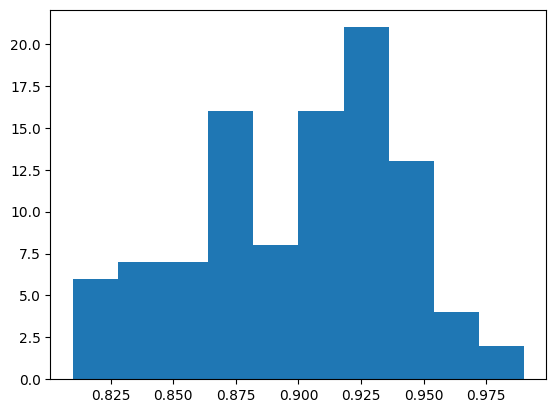

In [4]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (3 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

In [5]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

class FeatureSelector:
    def __init__(self, num_features):
        self.n = num_features

    def fit(self, X, y):
        covariance = ((X - X.mean(axis=0)) * (y[:, np.newaxis] - y.mean())).mean(axis=0)
        self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

    def transform(self, X):
        return X[:, self.best_feature_ids]

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

num_features_total = 1000
num_features_best = 100
N = 100

X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

X_best = FeatureSelector(num_features_best).fit_transform(X, y)

model = LinearSVC()

cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

accuracy_on_same_data = accuracy_score(y, model.fit(X_best, y).predict(X_best))
print(f"Accuracy on the same data is {accuracy_on_same_data}")

CV score is 0.9700000000000001
Accuracy on the same data is 1.0


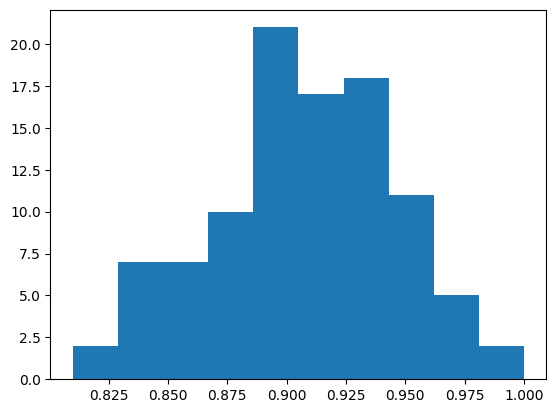

In [6]:
results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

In the FeatureSelector class, you are selecting the best features based on their correlation with the target variable (y).

You then fit the FeatureSelector on the entire dataset (X) and select the best features.

After selecting the best features, you apply this transformation (X_best) and then perform cross-validation on it with the classification model.

The problem is that in the feature selection step, you are using information from the target variable y to select the best features. This creates data leakage, as you are using information from the target variable that you should not have in a real-world scenario. In a real-world scenario, the model should not have access to the target variable when selecting features, as it doesn't know the true labels.

The reason you're getting a high accuracy in cross-validation is that the feature selection process effectively handpicks the features that are most correlated with the random y labels you generated, leading to a model that appears to perform well on the same data that was used to select the features.

To avoid this issue, you should separate the feature selection step from the cross-validation process. You can use cross-validation for feature selection as well, making sure that each fold in cross-validation uses a separate subset of the data for feature selection, and the selected features are then used for model training and testing. This prevents data leakage and provides a more realistic estimate of your model's performance.

In this code, I use the SelectKBest class from scikit-learn to select the best features, and it's part of a pipeline with the classification model. This ensures that feature selection is done separately within each fold of the cross-validation process, avoiding data leakage.

## Task 2 (3 points)

Let's come back to Task 3 of Data Handling HW.
Build a model with KNeighborsClassifier to get a higher accuracy on 5-fold Cross Validation than you achieve using your previosly fitted model (you can just copy the params from the previous notebook).

Use `sklearn.model_selection.GridSearchCV` to find best parameters.  You may check the parameters'  description as follows:
``` python
help(KNeighborsClassifier)
```

In [7]:
!wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv

--2023-11-04 10:08:57--  https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>]  58.89K  --.-KB/s    in 0.009s  

2023-11-04 10:08:57 (6.09 MB/s) - ‘train.csv.1’ saved [60302/60302]



In [8]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

data = pd.read_csv("train.csv", index_col='PassengerId')

In [9]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer

data = pd.read_csv("train.csv", index_col='PassengerId')

# numeric features
X = data[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]

# target (y)
y = data['Survived']

# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputation
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Feature selection
selector = SelectKBest(score_func=chi2, k=3)  # You can adjust 'k' as needed
X_train_selected = selector.fit_transform(X_train, y_train)

# parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

# Best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_rf_model = RandomForestClassifier(random_state=42, **best_params)
best_rf_model.fit(X_train_selected, y_train)

X_test_selected = selector.transform(X_test)

# predictions
y_pred = best_rf_model.predict(X_test_selected)

# accuracy
test_accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Score (Accuracy):", best_score)
print("Test Accuracy:", test_accuracy)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Score (Accuracy): 0.7036540923864868
Test Accuracy: 0.7486033519553073
